# task3-决策树

决策树是一种树型结构的机器学习算法,它每个节点验证数据一个属性,根据该属性进行分割数据,将数据分布到不同的分支上,直到叶子节点,叶子结点上表示该样本的label. 每一条从根节点到叶子节点的路径表示分类[回归]的规则. 下面我们先来看看sklearn中决策树怎么用.

## sklearn 接口

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_boston
from sklearn import tree

from sklearn.model_selection import train_test_split

In [11]:
# 分类树
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

print ("Classifier Score:", clf.score(X_test, y_test))

Classifier Score: 0.9333333333333333


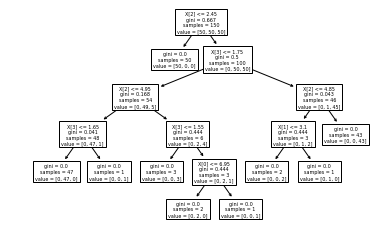

In [5]:
tree.plot_tree(clf.fit(X, y)) 
plt.show()

In [12]:
# 回归树
X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

print ("Regression Score:", clf.score(X_test, y_test))


Regression Score: 0.7572796221804655


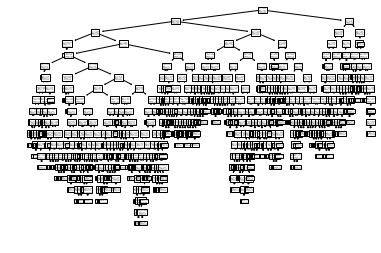

In [7]:
tree.plot_tree(clf.fit(X, y)) 
plt.show()

## 决策树详解
### 信息论基础
首先先来几个概念,我们后面介绍决策树原理的时候会提到,这里可以先扫一眼,用到的时候再回来看.
1. 熵和信息熵

熵，热力学中表征物质状态的参量之一，用符号S表示，其物理意义是体系混乱程度的度量. 可以看出,熵表示的是体系的不确定性大小. 熵越大, 物理的不确定性越大. 1948年，香农提出了“信息熵”的概念，才解决了对信息的量化度量问题. 同理, 信息熵越小,数据的稳定性越好,我们更加相信此时数据得到的结论. 换言之, 我们现在目的肯定熵越小,机器学习得到的结果越准确. 

信息熵表示随机变量不确定性的度量,设随机标量X是一个离散随机变量，其概率分布为:
$$P(X=x_i)=p_i, i=1,2,...,n$$
则随机变量X的熵定义为:
$$H(X)=-\sum_{i=1}^{n}p_ilog{p_i}$$
熵越大，随机变量的不确定性就越大，当$p_i=\frac{1}{n}$时，
随机变量的熵最大等于logn，故$0 \leq H(P) \leq logn$.

2. 条件熵

条件熵就是在给定X的条件的情况下，随机标量Y的条件，记作$H(Y|X)$，可以结合贝叶斯公式进行理解，定义如下
$$H(Y|X)=\sum_{i=1}^{n}p_iH(Y|X=x_i)$$
这里$p_i=P(X=x_i),i=1,2,...,n$.
一般在基于数据的估计中，我们使用的基于极大似然估计出来的经验熵和经验条件熵.

3. 联合熵

联合熵是相对两个及其以上的变量而言的, 两个变量X和Y的联合信息熵为:

$$ H(X,Y)=-\sum_x \sum_y P(x,y)log_2[P(x,y)] $$

其中: x和y是X和Y的特定值, 相应地, 是这些值一起出现的联合概率, 若为0, 则定义为0.

对于两个以上的变量$X_1,...,X_n$,一般形式位:
$$H(X_1,...,X_n)=-\sum_{x_1}\cdot \cdot \cdot\sum_{x_n}P(x1,...,x_n)log_2[P(x_1,...,x_n)]$$

性质:
- 大于每个独立的熵
$$H(X,Y) \geq max(H(X),H(Y))$$
$$H(X_1,...,X_n) \geq max(H(X_1),...,H(X_n))$$
- 小于独立熵的和
$$H(X_1,...,X_n) \leq sum(H(X_1),...,H(X_n))$$
- 和条件熵的关系
$$H(Y|X)=H(X,Y)-H(X)$$
- 和互信息的关系
$$I(Y;X)=H(X)+H(Y)-H(X,Y)=H(Y)-(H(X,Y)-H(X))$$


4. 信息增益

信息增益又叫**互信息**,它表示的是在的得知特征X的信息后,使得类Y的信息的不确定性(熵)减少的程度. 
$$g(Y,X)=H(Y)-H(Y|X)$$


5. 基尼指数

基尼指数又称基尼系数或者基尼不纯度,基尼系数是指国际上通用的、用以衡量一个国家或地区居民收入差距的常用指标. 在信息学中,例如分类问题, 假设有K个类,样本点属于第k类的概率是$p_k$,则该概率分布的基尼指数定义为:
$$Gini(p)=\sum_k^Kp_k(1-p_k)=1-\sum_k^Kp_k^2$$


### 决策树解释

决策树是什么东西？就是我们平常所说的if-then条件，我们把它组合成树的结构. 决策树中有两种结点，叶子结点和非叶子结点. 其中非叶节点代表的条件，叶子结点表示的实例所属的类别. 

我们如何生成这个决策树呢，最主要的一点就是选择那个特征作为当前树的分割结点，这就叫做特征选择，有了特征选择就有了决策树的生成，最后我们还有进行决策树剪枝(后面会提到为什么剪枝). 

看个统计学习方法上的例子:

现在我们有下面一张表的数据，想生成一个决策树模型，预测某个人是否符合贷款条件. 
<center><img src="https://i.ibb.co/xm7d5LV/Screenshot-from-2018-12-27-17-32-10.png" border="0"></center>

现在假如我们通过"某种方法"构造了一颗下面的决策树. 从下图可以看到特征对应的是非叶子结点，如果这个被分到这个叶节点，就预测为这个叶节点的类别. 从图中我们可以知道以下两点:
1. 每一个叶子节点都对应一条从根节点到叶节点的规则，这表示决策树是if-then规则的集合
2. 如果一个实例到达了某个叶节点，一定表示它满足了从根节点到该叶子节点的所有条件，而后才得到类别，这不就是先满足条件再得到概率嘛，我们一般叫做条件概率分布. 
<center><img src="https://i.ibb.co/3TQDgwH/Screenshot-from-2018-12-27-17-47-01.png" alt="Screenshot-from-2018-12-27-17-47-01" border="0"></center>

> 问题来了，为什么我们要选择是否有房子作为第一个构造特征呢？我们构造学习模型，会遵守经验风险最小化或者似然函数极大规则，选择损失函数，我们如何根据风险最小化，选择特征呢？



## ID3&C4.5

### 数据

给定训练数据集

$$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$$

其中，$x_i=(x_i^{(1)},x_i^{(2)},...,x_i^{(n)})^T$特征向量，n是特征的个数，$y_i \in \{1,2,...,K\}$表示类别. N是样本个数. 基于这个数据生成决策树模型. 

### 决策树

常见的决策树模型有以下三种(CART决策树既可以做分类也可以做回归):

```
1. ID3: 使用信息增益准则选择特征, 相当于用极大似然法进行概率模型选择. 
2. C4.5: 和ID3算法相似, 只是用信息增益比选择特征. 
3. CART: 递归构建二叉决策树, 回归树:使用平方误差; 分类树:使用基尼指数. 
```

| model | feature select | 树的类型 |计算公式|
|:-----:|:--------------:|:------:|:------:|
|ID3    |{分类:信息增益}|多叉树|$g(D,A)=H(D)-H(D\|A)$|
|C4.5   |{分类:信息增益比}|多叉树|$g_R(D,A)=\frac{g(D,A)}{H_A(D)}$|
|CART   |{回归:平方误差;分类:基尼指数}|二叉树|$Gini(p)=\sum_{k=1}^{K}p_k(1-p_k)=1-\sum_{k=1}^{K}p_k^2$|

其中, $H_A(D)=H(D|A)$.

从表格中，我们总结(ID3,C4.5)决策树算法伪代码:
1. 输入:数据集D，特征集合A，阈值e
2. 输出:决策树T
3. 如果D中所有实例输出同一类$C_k$, 则T作为单节点树，并将类$C_k$作为该节点的类标记，返回T;
4. 若$A=\varnothing$,则T为单节点树，将D中实例数最多的类$C_k$作为该节点的类标记，返回T；
5. 否则，根据**信息增益**(ID3)或者**信息增益比**(C4.5)计算特征A对D的值，选择当前最优的特征$A_g$;
6. 如果$A_g$的信息增益小于阈值e，则置T为单节点数，并将D中实例最多的类$C_k$作为当前的类标记，返回T；
7. 否则，根据$A_g$中的每一个不同的$a_i$,根据$A_g=a_i$将D分成若干个非空子集，对于第i个子节点，以$D_i$为数据集，以$A-{A_g}$为特征集，递归(重复3-6)构造决策树$T_i$,返回$T_i$.
8. 对决策树模型T进行剪枝.

### 过拟合和剪枝

决策树建立的过程中,只考虑经验损失最小化,没有考虑结构损失. 因此可能在训练集上表现良好,但是会出现过拟合问题.(我们构造决策树的时候，是完全的在训练数据上得到最优的模型. 这就是过拟合问题，训练误差很小，但是验证集上就不怎么好用.) 为了解决过拟合,我们从模型损失进行考虑:

$$模型损失=经验风险最小化+正则项=结构风险最小化$$

思路很简单,给损失函数加上正则项再进行优化. 正则项表示树节点的个数,因此有如下公式:

$$C_{\alpha}(T)=C(T)+\alpha|T|$$

进一步详细定义,解决问题:


重新定义损失函数，树的叶子节点个数|T|,t是树T的叶节点，该叶节点有$N_t$个样本，其中k类的样本点有$N_{tk}$个，k=1,2，...,K, $H_t(T)$是叶子节点t经验熵，$\alpha \leq 0$是参数,平衡经验损失和正则项，得到计算公式如下:
$$C_{\alpha}(T)=\sum_{t=1}^{|T|}N_tH_t(T)+\alpha|T|$$
其中，经验熵为:
$$H_t(T)=-\sum_{k}\frac{N_{tk}}{H_t}log\frac{N_{tk}}{H_t}$$
这是有:
$$C_{\alpha}=C(T)+\alpha|T|$$
决策树剪枝优化过程考虑了在训练数据上的经验风险最小化和减小模型复杂度两个方向. 因为加了正则项，所有我们基于贪心的思想进行剪枝，因为当剪掉一个树节点，虽然经验风险增加了，但是模型复杂度降低了，我们基于两个方面的平衡进行剪枝，如果剪掉之后，总的风险变小，就进行剪枝.       
算法:       
输入: 算法产生的整个决策树，参数$\alpha$        
修剪之后的树$T_{\alpha}$        
1. 计算每个节点的经验熵
2. 递归从树的叶节点向上回溯，假设将某个叶节点回缩到其父节点前后的整体树对应的$T_B$和$T_A$,对应的损失分别是$C_{\alpha}(T_B)$和$C_{\alpha}(T_A)$，如果:
   $$C_{\alpha}(T_A) \leq C_{\alpha}(T_B)$$
    表示，剪掉之后，损失减小，就进行剪枝.
3. 重复2，直到不能继续为止，得到损失函数最小的子树$T_{\alpha}$. 



**4. 动态规划剪枝**.

可以看出来上述算法是一个递归问题,存在很多重复项计算,这里我们使用dfs+备忘录进行加速计算,这种方法和动态规划类似.

算法:       
输入: 算法产生的整个决策树，参数$\alpha$        
修剪之后的树$T_{\alpha}$ 
1. dp[所有树的节点] = {0}; 保留所有几点的信息熵
2. 计算每个cur_node节点的经验熵, {if dp[cur_node] 直接返回, 否则, 执行2}
3. 递归从树的叶节点向上回溯，假设将某个叶节点回缩到其父节点前后的整体树对应的$T_B$和$T_A$,对应的损失分别是$C_{\alpha}(T_B)$和$C_{\alpha}(T_A)$，如果:
   $$C_{\alpha}(T_A) \leq C_{\alpha}(T_B)$$
    表示，剪掉之后，损失减小，就进行剪枝.
    
$$dp[cur_node] = C_{\alpha}(T_A)$$
4. 重复2，直到不能继续为止，得到损失函数最小的子树$T_{\alpha}$. 



## CART
分类与回归树(classification and regression tree, CART)与上述决策树的不同，
1. 既可以做分类又可以做回归. 
2. 是二叉树，内部节点特征取值，只有yes和no两个选项      
同样地，先进行决策树构造，在基于验证集上进行CART决策树的剪枝，既然是回归和分类树，我们就分别介绍回归和分类两种情况.
+ 分类: gini指数
+ 回归: 平方误差
定义数据格式:
$$D={(x_1,y_1),(x_2,y_2),...,(x_N,y_N)}$$
其中，$x_i$是向量，当回归问题时，$y_i$是连续变量; 分类问题时，$y_i$是离散变量. 

### 回归树(Regerssion Tree)
算法:       
在训练数据上，根据某一个特征将每个区域划分为两个子区域并决定每个子区域的输出值，递归构建二叉树.
1. 选择最优切分变量j和切分点s，求解
$$min_{j,s}[min_{c_1}\sum_{x_i \in R_1(j,s)}(y_i-c_1)^2 + min_{c_2}\sum_{x_i \in R_2(j,s)}(y_i-c_2)^2]$$
遍历变量j，对固定的切分变量j扫描所有的s，找到使得上式最小的对(j,s).
2. 使用选定的(j,s)划分区域并决定相应的输出值:
   $$R_1(j,s)=\{x|x^{(j)} \leq s \}, R_2(j,s)=\{x|x^{(j)} > s \},$$
   $$c_m=\frac{1}{N_m}\sum_{x_i \in R_m(j,s)}y_i, x \in R_m, m=1,2$$
3. 继续对两个子区域调用1和2，知道满足条件
4. 将输入空间划分为M个区域$R_1,R_2,...,R_m$,生成决策树:
   $$f(x)=\sum_{m=1}^{M}c_mI(x \in R_m)$$

### 分类树(classification tree)
基尼指数计算公式如下:
$$Gini(p)=\sum_{k=1}^{K}p_k(1-p_k)=1-\sum_{k=1}^{K}p_k^2$$
基于数据D，得到:
$$Gini(D)=1-\sum_{k=1}^{K}p_k^2$$
其中,$C_k$是D中所属第k类的样本子集，K是类的个数.        
如果样本集合D根据特征A是否取某一可能取值a被被划分成$D_1$和$D_2$两个部分.
$$D_1=\{(x,y) \in D | A(x)=a \}, D_2= D-D_1$$
在特征A的条件下，集合D的基尼指数定义为:
$$Gini(D,A)=\frac{|D_1|}{D}Gini(D_1)+\frac{|D_2|}{D}Gini(D_2)$$
基尼指数和熵一样，同样表示集合D的不确定性，基尼指数(Gini(D,A))表示根据调教A=a后的集合D的不确定性，基尼指数越大，表示数据D的不确定性越大.

算法:       
输入:训练数据D，停止计算的条件      
输出:CART决策树     
1. 计算所有特征A的每一个值a对应的条件基尼指数的值，选择最优的划分得到$D_1$和$D_2$.
2. 递归对两个数据集$D_1$和$D_2$继续调用1，知道满足条件.
3. 生成CART树的分类树. 
4. 预测的时候，根据决策树，x落到的叶子节点对应的类别表示这个预测x的类别.

### CART剪枝
从上面两个算法的不同可以看出，只是在label的设置和决策节点选择的方式不同，整个架构依然是决策树的常用的架构. 而且上面的树的构建过程，都是基于训练数据的经验风险最小化，没有使用带有正则项的结构风险最小化，这样的模型容易发生过拟合，为了不让模型过拟合，我们需要进行模型的剪枝.

**CART树的剪枝有很多难点和有意思的地方让我们开慢慢解开这层面纱**
CART剪枝算法有两步组成:
1. 从生成算法产生的决策树$T_0$底端开始不断剪枝，直到$T_0$的根节点，形成一个子树序列$\{T_0,T_1,...,T_n\}$.
2. 通过交叉验证的方法在独立的验证数据集上堆子序列进行测试，得到最优子树

损失函数:
$$C_{\alpha}(T)=C(T)+\alpha|T|$$
其中，T为任意子树，$C(T)$是在训练数据上的预测误差，|T|是树的叶子节点的个数,$\alpha \geq 0$是参数，$C_{\alpha}(T)$是参数$\alpha$是的子树T的整体的损失，参数$\alpha$是平衡训练数据拟合程度和模型复杂度的权重.             
对于固定的$\alpha$,一定存在使损失函数$C_{\alpha}(T)$最小的子树，将其记作$T_{\alpha}$. 我们可以理解为每一个$\alpha$都对应一个最有子树和最小损失. 

**而且**已经得到证明，可以用递归的方法对树进行剪枝. 将$\alpha$从小增大，$0=\alpha_0<\alpha_1<...<\alpha_n<+\infty$,产生一系列的区间$[\alpha_i,\alpha_{i+1}),i=0,1,...,n$；剪枝得到的子树序列对应着区间$\alpha \in [\alpha_i,\alpha_{i+1}),i=0,1,...,n$的最有子树序列$\{T_0,T_1,...,T_n\}$. 

我们给出算法:       
输入: CART算法生成的决策树T_0.      
输出: 最优的决策树T_{\alpha}        
1. 设k=0, T=$T_0$.
2. 设 $\alpha=+\infty$.
3. 自下而上地对各个**内部节点t**计算$C(T_t),|T_t|$以及
   $$g(t)=\frac{C(t)-C(T_t)}{|T_t|-1}$$
   $$\alpha=min(\alpha,g(t))$$
    这里，$T_t$表示以t为根节点的子树，$C(T_t)$是对训练数据的预测误差，$|T_t|$是$T_t$的叶子节点个数.
4. 自上而下地访问内部节点t，如果有$g(t)=\alpha$,进行剪枝，并堆叶节点t以多数表决方法决定其类(分类，回归使用平均值)，得到树T.
5. 设$k=k+1,\alpha=\alpha,T_k=T$.
6. 如果T不是由根节点单独构成的树，则回到步骤4. 
7. 采用交叉验证法在子树序列$\{T_0,T_1,...,T_n\}$中选取最优子树$T_{\alpha}$.

接下面，我们不去看算法，来看书中给的一段文字的截图，这里截图是因为我要画图，进行比较解释，图中自由理论(哈哈):
<center><img src="https://i.ibb.co/RjszN94/cart.png" alt="cart" border="0"></center>

看懂这个图之后，再看算法一气呵成，因为我们假设每一次得到的树都有可能是最优的，所以不能直接去最后一个树，要使用交叉验证选择最有的决策树结构. 



## 问题精选
1. 决策树和条件概率分布的关系？
> 决策树可以表示成给定条件下类的条件概率分布. 决策树中的每一条路径都对应是划分的一个条件概率分布. 每一个叶子节点都是通过多个条件之后的划分空间，在叶子节点中计算每个类的条件概率，必然会倾向于某一个类，即这个类的概率最大.
2. 为什么使用信息增益，越大越能得到好的模型？
> 上面提到过，信息熵表示数据的混乱的程度，信息增益是信息熵和条件信息熵的差值，表示的熵减少的程度，信息增益越大，代表根据我们的决策树规则得到的数据越趋向于规整，这就是我们划分类别的目的. 
3. 为什么从信息增益变到信息增益比，目的何在？
> 信息增益根据特征之后的条件信息熵，这样的话偏向于特征取值较多的特征的问题，因此使用信息增益比对这个问题进行校正. 
4. 为什么要进行剪枝？
> 在构造决策树的过程中，我们的两个停止条件是，子集只有一个类别和没有可以选择的特征，这是我们全部利用了数据中的所有可以使用的信息，但是我们知道数据是可能有误差了，而且数据不足，我们需要得到更鲁棒的模型，剪枝的意义就是是的深度减小，这样的就相当于减少规则的情况下，决策树的性能反而不差，使其更加鲁棒.
5. ID3和C4.5算法可以处理实数特征吗？如果可以应该怎么处理？如果不可以请给出理由？
> ID3和C4.5使用划分节点的方法分别是信息增益和信息增益比，从这个公式中我们可以看到 这是处理类别特征的方法，实数特征能够计算信息增益吗？我们可以定义X是实数特征的信息增益是，$$G(D|X:t)=H(D)-H(D|X:t)$$
其中
$$H(D|X:t)=H(D|x \leq t)p(x \leq t)+H(D|x>t)p(x>t)$$ $$G(D|X)=max_t=G(D|X:t)$$
对于每一个实数可以使用这种方式进行分割. 除此之外,我们还可以使用特征的分桶，将实数特征映射到有限个桶中，可以直接使用ID3和C4.5算法.
6. 基尼系数存在的问题? 
> 基尼指数偏向于多值属性;当类数较大时，基尼指数求解比较困难;基尼指数倾向于支持在两个分区中生成大小相同的测试。

## sklearn 决策树参数

我们掌握理论之后,就去看看sklearn中决策树的实现.

DecisionTreeClassifier: sklearn中多分类决策树的接口.

Paramters: 
```
criterion : str, 可选参数(default="gini")
    这个参数表示使用什么度量划分的质量. gini: 表示使用基尼指数.
    entropy: 表示使用的是信息增益.
splitter : str, optional(default="best")
    选择分割节点的策略. 支持最优(best)和随机(random)两种方式.

max_depth : int or None, optional(dafault=None)
    表示决策树的最大深度. None: 表示不设置深度,可以任意扩展,
    直到叶子节点的个数小于min_samples_split个数.
min_samples_split : int, float, optional(default=2)
    表示最小分割样例数.
    if int, 表示最小分割样例树,如果小于这个数字,不在进行分割.
    if float, 表示的比例[0,1],最小的分割数字=ceil(min_samples_split * n_samples)

min_samples_leaf : int, float, optional (default=1)
    表示叶节点最少有min_samples_leaf个节点树,如果小于等于这个数,直接返回.
    if int, min_samples_leaf就是最小样例数.
    if float, 表示的比例[0,1],最小的样例数=ceil(min_samples_leaf * n_samples)
    
min_weight_fraction_leaf : float, optional (default=0.) 
    
max_features : int, float, str or None, optional(default=None)
    进行最优分割时,特征的最大个数.
    if int, max_features是每次分割的最大特征数
    if float, int(max_features * n_features)作为最大特征数
    if "auto", 则max_features=sqrt(n_features)
    if "sqrt", 则max_features=sqrt(n_features)
    if "log2", 则max_features=log2(n_features)
    if None, 则max_features=n_features
    
random_state : int, RandomState instance or None, optional (default=None)
    随机化种子, if None,使用np.random随机产生
    
max_leaf_nodes : int or None, optional (default=None)
    最大的叶子节点个数,如果大于这个值,需要进行继续划分. None则表示没有限制.

min_impurity_decrease : float, optional (default=0.)
    分割之后基尼指数大于这个数,则进行分割.
    N_t / N * (impurity - N_t_R / N_t * right_impurity
                    - N_t_L / N_t * left_impurity)
                    
min_impurity_split : float, default=1e-7
    停止增长的阈值,小于这个值直接返回.
```

DecisionTreeRegressor: sklearn中回归树的接口.
```
criterion : str, optional (default=”mse”)
    其他参数和分类树类似.
    mse: mean squared error, which is equal to variance reduction as feature selection criterion and minimizes the L2 loss using the mean of each terminal node,
    mae: mean absolute error, which minimizes the L1 loss using the median of each terminal node.
```



## 代码实现

使用cart树的分类和回归两个接口,接口参考sklearn.


In [26]:
import copy
import numbers
import warnings
from math import ceil

import numpy as np
import pandas as pd
from scipy.sparse import issparse

In [27]:
class DecisionTree(object):
    """自定的树结构,用来保存决策树.
    
    Paramters:
    ----------
    col: int, default(-1)
        当前使用的第几列数据
    
    val: int or float or str, 分割节点
        分割节点的值, 
        int or float : 使用大于进行比较 
        str : 使用等于模式
    
    LeftChild: DecisionTree
        左子树, <= val
    
    RightChild: DecisionTree
        右子树, > val
    
    results: 
    """
    def __init__(self, col=-1, val=None, LeftChild=None, RightChild=None, result=None):
        self.col = col
        self.val = val
        self.LeftChild = LeftChild
        self.RightChild = RightChild
        self.result = result


class DecisionTreeClassifier(object):
    """使用基尼指数的分类决策树接口.
    
    Paramters:
    ---------
    max_depth : int or None, optional(dafault=None)
        表示决策树的最大深度. None: 表示不设置深度,可以任意扩展,
        直到叶子节点的个数小于min_samples_split个数.

    min_samples_split : int, optional(default=2)
        表示最小分割样例数.
        if int, 表示最小分割样例树,如果小于这个数字,不在进行分割.

    min_samples_leaf : int, optional (default=1)
        表示叶节点最少有min_samples_leaf个节点树,如果小于等于这个数,直接返回.
        if int, min_samples_leaf就是最小样例数.

    min_impurity_decrease : float, optional (default=0.)
        分割之后基尼指数大于这个数,则进行分割.
        N_t / N * (impurity - N_t_R / N_t * right_impurity
                        - N_t_L / N_t * left_impurity)

    min_impurity_split : float, default=1e-7
        停止增长的阈值,小于这个值直接返回.
    
    Attributes
    ----------
    classes_ : array of shape (n_classes,) or a list of such arrays
        表示所有的类
    
    feature_importances_ : ndarray of shape (n_features,)
        特征重要性, 被选择最优特征的次数,进行降序.
    
    tree_ : Tree object
        The underlying Tree object.
    """
    def __init__(self,
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_impurity_decrease=0.,
                 min_impurity_split=1e-7):        
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.classes_ = None
        self.max_features_ = None
        self.decision_tree = None
        self.all_feats = None
    
    
    def fit(self, X, y, check_input=True):
        """使用X和y训练决策树的分类模型.
        
        Parameters
        ----------
        X : {array-like} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``
            
        y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.
        
        check_input : bool, (default=True)
            Allow to bypass several input checking.
        
        Returns
        -------
        self : object
            Fitted estimator.
        """
        if isinstance(X, list):
            X = self.__check_array(X)
        if isinstance(y, list):
            y = self.__check_array(y)
        if X.shape[0] != y.shape[0]:
            raise ValueError("输入的数据X和y长度不匹配")
        
        self.classes_ = list(set(y))
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.DataFrame):
            y = y.values
        
        data_origin = np.c_[X, y]
#         print (data_origin)
        self.all_feats = [i for i in range(X.shape[1])]
        self.max_features_ = X.shape[0]
        
        data = copy.deepcopy(data_origin)
        self.decision_tree = self.__build_tree(data, 0)


    def __predict_one(self, input_x):
        """预测一个样例的返回结果.
        
        Paramters:
        ---------
        input_x : list or np.ndarray
            需要预测输入数据
        
        Returns:
        -------
        class : 对应的类
        """
        
        tree = self.decision_tree
        #============================= show me your code =======================
        # here
        while True:
            if  tree.result != None:
                pre_y=tree.result
                break 
            val=input_x[tree.col]
            tree = tree.LeftChild if val <= tree.val else tree.RightChild
        return pre_y
    
    
    def predict(self, test):
        """预测函数,
        
        Paramters:
        ---------
        test: {array-like} of shape (n_samples, n_features)
        
        Returns:
        result : np.array(list) 
        """
        result = []
        for i in range(len(test)):
            result.append(self.__predict_one(test[i]))
        return np.array(result)
    
    
    def score(self, vali_X, vali_y):
        """验证模型的特征,这里使用准确率.
        Parameters
        ----------
        vali_X : {array-like} of shape (n_samples, n_features)
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``

        vali_y : array-like of shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels) as integers or strings.
        
        Returns:
        -------
        score : float, 预测的准确率
        """
        vali_y = np.array(vali_y)
        pre_y = self.predict(vali_X)
        pre_score = 1.0 * sum(vali_y == pre_y) / len(vali_y)
        return pre_score
    
    
    def __build_tree(self, data, depth):
        """创建决策树的主要代码
        
        Paramters:
        ---------
        data : {array-like} of shape (n_samples, n_features) + {label}
            The training input samples. Internally, it will be converted to
            ``dtype=np.float32``
        
        depth: int, 树的深度
        
        Returns:
        -------
        DecisionTree
            
        """        
        labels = np.unique(data[:,-1])
        # 只剩下唯一的类别时,停止,返回对应类别
        if len(labels) == 1:
            return DecisionTree(result=list(labels)[0])
        
        # 遍历完所有特征时,只剩下label标签,就返回出现字数最多的类标签
        if not self.all_feats:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 超过最大深度,则停止,使用出现最多的参数作为该叶子节点的类
        if self.max_depth and depth > self.max_depth:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 如果剩余的样本数大于等于给定的参数 min_samples_split,
        # 则不在进行分割, 直接返回类别中最多的类,该节点作为叶子节点
        if self.min_samples_split >= data.shape[0]:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))

        # 叶子节点个数小于指定参数就进行返回,叶子节点中的出现最多的类
        if self.min_samples_leaf >= data.shape[0]:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))
        
        # 根据基尼指数选择每个分割的最优特征
        best_idx, best_val, min_gini = self.__getBestFeature(data)
#         print ("Current best Feature:", best_idx, best_val, min_gini)
        # 如果当前的gini指数小于指定阈值,直接返回
        if min_gini < self.min_impurity_split:
            return DecisionTree(result=np.argmax(np.bincount(data[:,-1].astype(int))))
        
        leftData, rightData = self.__splitData(data, best_idx, best_val)
        
        #============================= show me your code =======================
        # here
        leftDecisionTree = self.__build_tree(leftData,depth+1)
        rightDecisionTree = self.__build_tree(rightData,depth+1)
        #============================= show me your code =======================
        
        return DecisionTree(col=best_idx, val=best_val, LeftChild=leftDecisionTree, RightChild=rightDecisionTree)

    
    def __getBestFeature(self, data):
        """得到最优特征对应的列
        Paramters:
        ---------
        data: np.ndarray
            从data中选择最优特征
            
        Returns:
        -------
        bestInx, val, 最优特征的列的索引和使用的值.
        """
        best_idx = -1
        best_val = None
        min_gini = 1.0                
        # 遍历现在可以使用的特征列
        #============================= show me your code =======================

        # here
        for col in self.all_feats:
            d_col = data[:,col]
            for val in d_col:
                l_data, r_data = self.__splitData(data, col, val)
                l_gini = self.gini(labels=l_data[:,-1])
                r_gini = self.gini(labels=r_data[:,-1])
                n_gini = (l_gini*len(l_data)+r_gini*len(r_data))/len(data)
                
                if n_gini < min_gini:
                    best_idx = col
                    best_val = val
                    min_gini = n_gini
        
        
        #============================= show me your code =======================
        # 删除使用过的特征
        self.all_feats.remove(best_idx)
        
        return best_idx, best_val, min_gini
        
    
    def gini(self, labels):
        from collections import Counter
        """计算基尼指数.
        
        Paramters:
        ----------
        labels: list or np.ndarray, 数据对应的类目集合.
        
        Returns: 
        -------
        gini : float ``` Gini(p) = \sum_{k=1}^{K}p_k(1-p_k)=1-\sum_{k=1}^{K}p_k^2 ```
        
        """
        #============================= show me your code =======================    
        # here  
        labels = self.__check_array(labels)
        labels_dict= dict(Counter(labels))
    
        gini = 1
        for i in labels_dict:
            gini -= (labels_dict[i]/len(labels))**2
        
        #============================= show me your code =======================
        return gini
    
    
    def __splitData(self, data, featColumn, val):
        '''根据特征划分数据集分成左右两部分.
        Paramters:
        ---------
        data: np.ndarray, 分割的数据
        
        featColumn : int, 使用第几列的数据进行分割
        
        val : int or float or str, 分割的值
            int or float : 使用比较方式
            str : 使用相等方式
        
        Returns:
        -------
        leftData, RightData
            int or left: leftData <= val < rightData
            str : leftData = val and rightData != val
        '''
        if isinstance(val, str):
            leftData = data[data[:, featColumn] == val]
            rightData = data[data[:, featColumn] != val]
        elif isinstance(val, int) or isinstance(val, float):
            leftData = data[data[:, featColumn] <= val]
            rightData = data[data[:, featColumn] > val]
        return leftData, rightData
    
    
    def __check_array(self, X):
        """检查数据类型
        Parameters:
        ----------
        X : {array-like} of shape (n_samples, n_features)
            The training input samples.
        
        Retures
        -------
        X: {array-like} of shape (n_samples, n_features)
        """
        if isinstance(X, list):
            X = np.array(X)
        if not isinstance(X, np.ndarray) and not isinstance(X, pd.DataFrame):
            raise ValueError("输出数据不合法,目前只支持np.ndarray or pd.DataFrame")
        return X

In [28]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    # 分类树
    X, y = load_iris(return_X_y=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)

    print ("Classifier Score:", clf.score(X_test, y_test))

Classifier Score: 0.9666666666666667


## 参考
1. 统计学习方法-决策树
2. https://blog.csdn.net/fool_ran/article/details/86257713
3. https://baike.baidu.com/item/%E7%86%B5/101181?fr=aladdin
4. https://github.com/datawhalechina/Datawhale_Learning/blob/master/doc/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0/%E5%88%9D%E7%BA%A7%E7%AE%97%E6%B3%95%E6%A2%B3%E7%90%86/%E5%AD%A6%E4%B9%A0%E4%BB%BB%E5%8A%A1/Task3.md
5. https://baike.baidu.com/item/%E5%9F%BA%E5%B0%BC%E7%B3%BB%E6%95%B0?fromtitle=%E5%9F%BA%E5%B0%BC%E6%8C%87%E6%95%B0&fromid=360504
6. https://baike.baidu.com/item/%E8%81%94%E5%90%88%E7%86%B5/22709235?fr=aladdin
7. https://github.com/datawhalechina/Daily-interview/blob/master/machine-learning/DecisionTree.md
8. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
9. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
10. https://github.com/michaeldorner/DecisionTrees/blob/master/03_Python%20Code/implementation.py